In [150]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from synesis_data_structures.time_series.definitions import TIME_SERIES_DATA_SECOND_LEVEL_ID, ENTITY_METADATA_SECOND_LEVEL_ID
from synesis_data_structures.time_series.df_dataclasses import TimeSeriesStructure


sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (20, 8)
plt.rcParams["font.size"] = 17


data_path = Path(
    "/Users/eiriksteen/Personal/project/synesis/project_server/server/data_storage/integrated/54f499bf-7a82-44bd-83b3-589fe5b3a234/cefaf112-b7f6-4dc5-9b67-79cdc3f63b36")

df = pd.read_parquet(
    data_path / f"{TIME_SERIES_DATA_SECOND_LEVEL_ID}.parquet")

metadata = pd.read_parquet(
    data_path / f"{ENTITY_METADATA_SECOND_LEVEL_ID}.parquet")


group = TimeSeriesStructure(
    time_series_data=df,
    entity_metadata=metadata,
    feature_information=None
)

group.time_series_data

percent_weighted_ili  ...       ot
entity_id date                                             ...         
national  2002-01-01 00:00:00+00:00              1.222620  ...   176569
          2002-01-08 00:00:00+00:00              1.333440  ...   186355
          2002-01-15 00:00:00+00:00              1.319290  ...   192469
          2002-01-22 00:00:00+00:00              1.494840  ...   207512
          2002-01-29 00:00:00+00:00              1.471950  ...   223208
...                                                   ...  ...      ...
          2020-06-02 00:00:00+00:00              0.839059  ...  1525058
          2020-06-09 00:00:00+00:00              0.895958  ...  1538038
          2020-06-16 00:00:00+00:00              0.910926  ...  1528103
          2020-06-23 00:00:00+00:00              0.946945  ...  1542813
          2020-06-30 00:00:00+00:00              0.963716  ...  1509928

[966 rows x 7 columns]

In [151]:
from dataclasses import dataclass
from typing import List, Optional, Dict
import pathlib
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import joblib
from synesis_data_structures.time_series.df_dataclasses import TimeSeriesStructure


@dataclass
class ModelConfig:
    weights_save_dir: Optional[pathlib.Path] = None
    p: int = 1
    target_column: str = "cars_per_hour"


@dataclass
class TrainingArgs:
    pass


@dataclass
class TrainingInput:
    function_args: TrainingArgs
    input_time_series: TimeSeriesStructure


@dataclass
class TrainingOutputVariables:
    mse: float
    coefficients: List[float]


@dataclass
class TrainingOutput:
    fitted_time_series: TimeSeriesStructure
    output_variables: TrainingOutputVariables


@dataclass
class InferenceArgs:
    forecast_horizon: int = 1


@dataclass
class InferenceInput:
    function_args: InferenceArgs
    input_time_series: TimeSeriesStructure


@dataclass
class InferenceOutput:
    forecast_time_series: TimeSeriesStructure


class ARModel:
    """
    ARModel

    Simple Autoregressive (AR) model for time series forecasting using scikit-learn's LinearRegression.

    Fits an AR(p) model by regressing the current value on the previous p lagged values.
    Suitable for univariate time series forecasting on datasets like ETTh1.

    Configuration:
      - weights_save_dir (Path): Directory to save/load model weights
      - p (int): Order of the AR model (number of lagged terms)
      - target_column (str): Name of the column to forecast

    Methods:
      - run_training: Trains the AR model on historical time series data
      - load_trained_model: Loads a previously trained model from disk
      - run_inference: Generates forecasts using the trained model

    Example:
    >>> config = ModelConfig(p=2, target_column='OT', weights_save_dir=Path('./weights'))
    >>> model = ARModel(config)
    >>> training_output = model.run_training(training_input)
    >>> model.load_trained_model()
    >>> forecast = model.run_inference(inference_input)
    """

    def __init__(self, model_config: ModelConfig):
        self.model_config = model_config
        self.models: Dict[str, LinearRegression] = {}

    def run_training(self, training_input: TrainingInput) -> TrainingOutput:
        """
        run_training(training_input) -> TrainingOutput

        Trains the AR model by fitting LinearRegression on lagged features derived from the target column.
        Automatically saves model weights (coefficients) to self.model_config.weights_save_dir.

        Args:
          training_input (TrainingInput):
            - function_args (TrainingArgs): No parameters required for training
            - input_time_series (TimeSeriesStructure): Historical time series data with datetime index and the target_column present in the data.
              The data should have sufficient length for creating p lagged features.

        Returns:
          training_output (TrainingOutput):
            - fitted_time_series (TimeSeriesStructure): Fitted values for the training data, aligned with the input time series
            - output_variables (TrainingOutputVariables):
                - mse (float): Mean squared error on the training data
                - coefficients (List[float]): The AR coefficients (including intercept)

        Example:
        >>> training_input = TrainingInput(
        ...     function_args=TrainingArgs(),
        ...     input_time_series=historical_data
        ... )
        >>> output = model.run_training(training_input)
        >>> output.output_variables.mse
        0.05
        """
        data = training_input.input_time_series.time_series_data
        target = self.model_config.target_column
        p = self.model_config.p
        mse_list = []
        coeff_list = []
        fitted_dfs = []
        entities = data.index.get_level_values(0).unique()
        for entity in entities:
            entity_data = data.loc[entity].sort_index()
            y = entity_data[target].values
            if len(y) <= p:
                continue
            X = np.array([y[i-p:i] for i in range(p, len(y))])
            y_train = y[p:]
            model = LinearRegression()
            model.fit(X, y_train)
            y_pred = model.predict(X)
            mse = mean_squared_error(y_train, y_pred)
            mse_list.append(mse)
            coeff = [model.intercept_] + model.coef_.tolist()
            coeff_list.append(coeff)
            self.models[entity] = model
            fitted_y = np.full(len(y), np.nan)
            fitted_y[p:] = y_pred
            fitted_df = pd.DataFrame(
                {target: fitted_y}, index=entity_data.index)
            fitted_df.index = pd.MultiIndex.from_tuples(
                [(entity, ts) for ts in fitted_df.index], names=['entity', 'timestamp'])
            fitted_dfs.append(fitted_df)
        avg_mse = np.mean(mse_list) if mse_list else 0.0
        if coeff_list:
            avg_coeff = np.mean(np.array(coeff_list), axis=0).tolist()
        else:
            avg_coeff = [0.0] * (p + 1)
        fitted_ts_data = pd.concat(fitted_dfs)
        fitted_ts = TimeSeriesStructure(
            time_series_data=fitted_ts_data,
            entity_metadata=training_input.input_time_series.entity_metadata,
            feature_information=training_input.input_time_series.feature_information
        )
        output_variables = TrainingOutputVariables(
            mse=avg_mse, coefficients=avg_coeff)
        if self.model_config.weights_save_dir:
            self.model_config.weights_save_dir.mkdir(
                parents=True, exist_ok=True)
            joblib.dump(
                self.models, self.model_config.weights_save_dir / 'models.pkl')
        return TrainingOutput(fitted_time_series=fitted_ts, output_variables=output_variables)

    def load_trained_model(self):
        """
        load_trained_model()

        Loads the trained AR models from self.model_config.weights_save_dir.

        This method must be called before run_inference if using a pre-trained model.
        """
        if self.model_config.weights_save_dir:
            self.models = joblib.load(
                self.model_config.weights_save_dir / 'models.pkl')

    def run_inference(self, inference_input: InferenceInput) -> InferenceOutput:
        """
        run_inference(inference_input) -> InferenceOutput

        Generates forecasts using the trained AR model by iteratively predicting future values based on lagged historical data.
        Assumes the model has been trained or load_trained_model() has been called.

        Args:
          inference_input (InferenceInput):
            - function_args (InferenceArgs):
                - forecast_horizon (int): Number of time steps to forecast ahead
            - input_time_series (TimeSeriesStructure): Historical time series data to base the forecast on, must include the target_column.
              Should have at least p observations for initial lagged features.

        Returns:
          inference_output (InferenceOutput):
            - forecast_time_series (TimeSeriesStructure): Forecasted values for the specified horizon, with datetime index continuing from the input data

        Example:
        >>> inference_input = InferenceInput(
        ...     function_args=InferenceArgs(forecast_horizon=10),
        ...     input_time_series=historical_data
        ... )
        >>> output = model.run_inference(inference_input)
        """
        forecast_horizon = inference_input.function_args.forecast_horizon
        data = inference_input.input_time_series.time_series_data
        entity_meta = inference_input.input_time_series.entity_metadata
        target = self.model_config.target_column
        p = self.model_config.p
        forecast_dfs = []
        entities = data.index.get_level_values(0).unique()
        for entity in entities:
            if entity not in self.models:
                continue
            model = self.models[entity]
            entity_data = data.loc[entity].sort_index()
            y = entity_data[target].values
            if len(y) < p:
                continue
            current = y[-p:].tolist()
            forecasts = []
            for _ in range(forecast_horizon):
                pred = model.predict([current])[0]
                forecasts.append(pred)
                current = current[1:] + [pred]
            last_ts = entity_data.index[-1]
            freq_str = entity_meta.loc[entity,
                                       'sampling_frequency'] if 'sampling_frequency' in entity_meta.columns else 'h'
            delta_map = {
                'h': pd.Timedelta(hours=1),
                'd': pd.Timedelta(days=1),
                'w': pd.Timedelta(weeks=1),
                'm': pd.Timedelta(days=30),
                'y': pd.Timedelta(days=365)
            }
            delta = delta_map.get(freq_str, pd.Timedelta(hours=1))
            if freq_str == 'h':
                freq = 'H'
            elif freq_str == 'd':
                freq = 'D'
            elif freq_str == 'm':
                freq = 'M'
            elif freq_str == 'w':
                freq = 'W'
            elif freq_str == 'y':
                freq = 'Y'
            else:
                freq = 'H'  # default
            new_ts = pd.date_range(start=last_ts + delta,
                                   periods=forecast_horizon, freq=freq)
            forecast_df = pd.DataFrame({target: forecasts}, index=new_ts)
            forecast_df.index.name = 'timestamp'
            # Create multiindex
            multi_index = pd.MultiIndex.from_tuples(
                [(entity, ts) for ts in forecast_df.index], names=['entity', 'timestamp'])
            forecast_df.index = multi_index
            forecast_dfs.append(forecast_df)
        if forecast_dfs:
            forecast_ts_data = pd.concat(forecast_dfs)
        else:
            forecast_ts_data = pd.DataFrame()
        forecast_ts = TimeSeriesStructure(
            time_series_data=forecast_ts_data,
            entity_metadata=inference_input.input_time_series.entity_metadata,
            feature_information=inference_input.input_time_series.feature_information
        )
        return InferenceOutput(forecast_time_series=forecast_ts)


def tune_params(lags_to_try: List[int]):
    min_mse, best_lag = float('inf'), None
    for lag in lags_to_try:
        model_config = ModelConfig(p=lag, target_column='ot', weights_save_dir=Path('./weights'))
        training_input = TrainingInput(
            function_args=TrainingArgs(), input_time_series=group)
        model = ARModel(model_config)
        output = model.run_training(training_input)
        if output.output_variables.mse < min_mse:
            print(f"New best lag: {lag} with MSE: {output.output_variables.mse}")
            min_mse = output.output_variables.mse
            best_lag = lag
    return best_lag


best_lag = tune_params([2, 96, 192, 384, 768])
model_config = ModelConfig(p=best_lag, target_column='ot', weights_save_dir=Path('./weights'))
model = ARModel(model_config)
model.load_trained_model()
inference_input = InferenceInput(
    function_args=InferenceArgs(forecast_horizon=6), input_time_series=group)
output = model.run_inference(inference_input)

inp = group.time_series_data.loc["national"]["ot"].tail(96)
forecast = output.forecast_time_series.time_series_data.loc["national"]["ot"]

New best lag: 2 with MSE: 3449218839.2190456
New best lag: 96 with MSE: 1689352721.0365508
New best lag: 192 with MSE: 1323906637.7288988
New best lag: 384 with MSE: 610687108.333564
New best lag: 768 with MSE: 7.64691077715155e-19


In [152]:
inp.tail(10)

date
2020-04-28 00:00:00+00:00    1504061
2020-05-05 00:00:00+00:00    1479946
2020-05-12 00:00:00+00:00    1438348
2020-05-19 00:00:00+00:00    1381381
2020-05-26 00:00:00+00:00    1537636
2020-06-02 00:00:00+00:00    1525058
2020-06-09 00:00:00+00:00    1538038
2020-06-16 00:00:00+00:00    1528103
2020-06-23 00:00:00+00:00    1542813
2020-06-30 00:00:00+00:00    1509928
Name: ot, dtype: int64

In [153]:
forecast

timestamp
2020-07-12 00:00:00+00:00    1.546312e+06
2020-07-19 00:00:00+00:00    1.566215e+06
2020-07-26 00:00:00+00:00    1.652313e+06
2020-08-02 00:00:00+00:00    1.728645e+06
2020-08-09 00:00:00+00:00    1.769488e+06
2020-08-16 00:00:00+00:00    1.764195e+06
Name: ot, dtype: float64

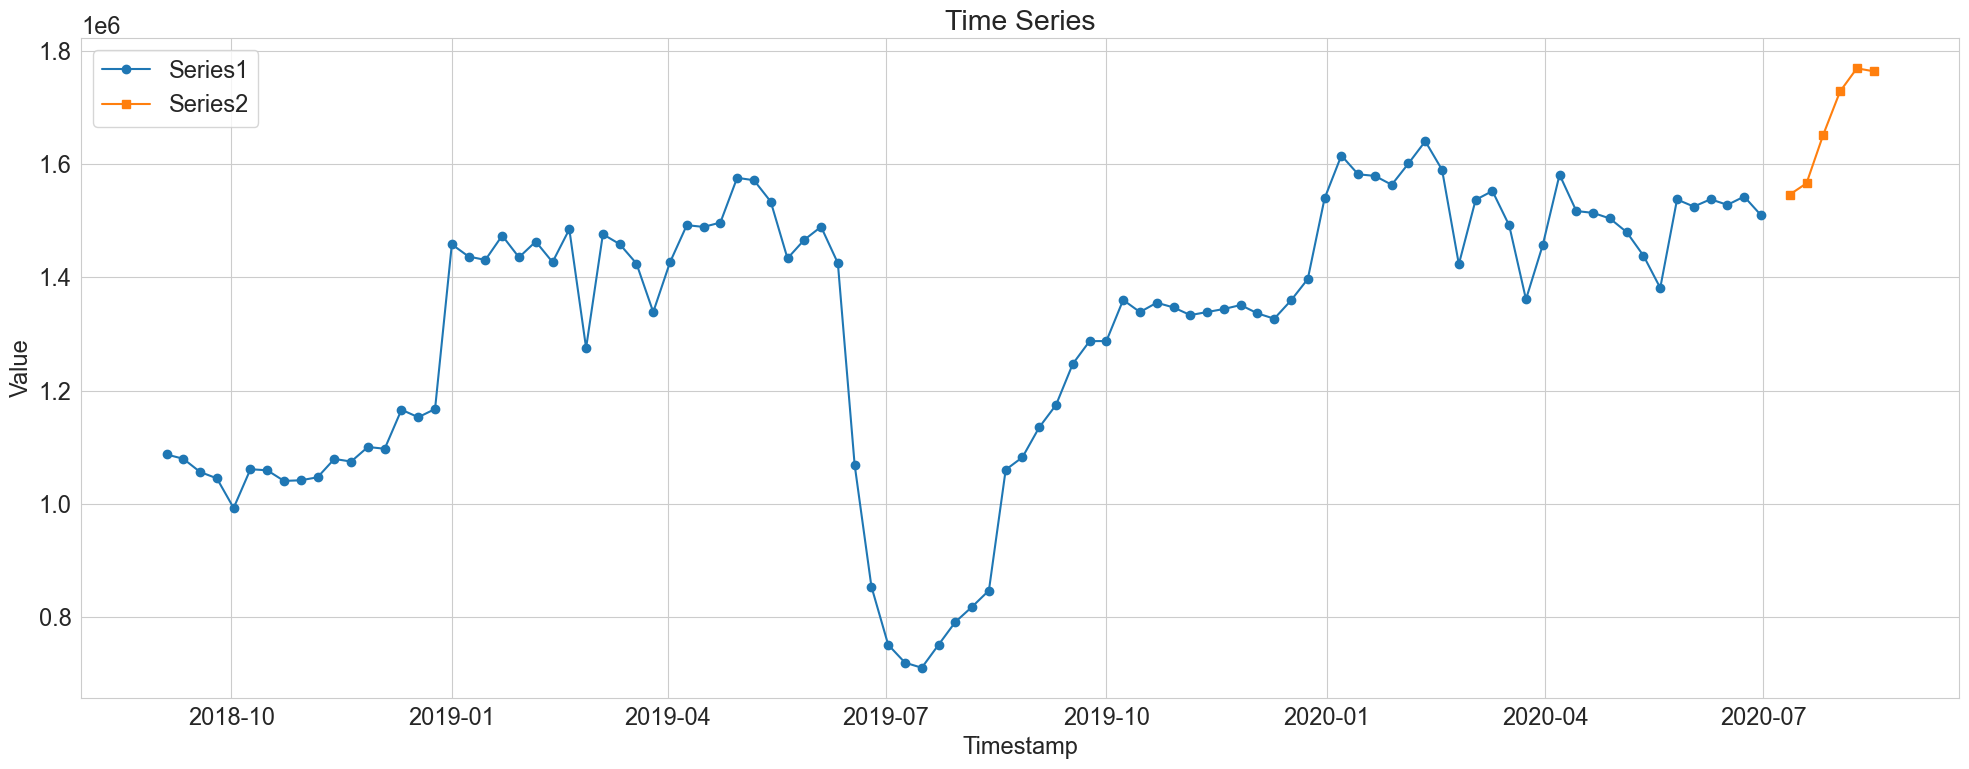

In [154]:
plt.figure()
plt.plot(inp.index, inp, label='Series1', marker='o')
plt.plot(forecast.index, forecast, label='Series2', marker='s')
plt.title('Time Series')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()